# Mesonet Data Pull

This notebook pulls and cleans data from the Mesonet API with the goal of outputting the daily high and low heat index for weather stations in the LA region for every day from January 1st 2018 to December 31st 2022. We pull air temperature and relative humidty data and calculate the heat index using the NOAA heat index methodology and also pull coordinate points.

In [3]:
import pandas as pd
import geopandas as gpd

import requests
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Define Selection Criteria including Stations and Variables

api_token = '#Insert Token Here#'

stations = { # Selected Stations and Station ID codes
    'Downtown LA/USC' : 'KCQT',
    'LAX': 'KLAX',
    'Hawthorne': 'KHHR',
    'Van Nuys': 'KVNY',
    'Burbank': 'KBUR',
    'Whiteman': 'KWHP',
    'Santa Monica': 'KSMO',
    'Torrance': 'KTOA',
    'Long Beach': 'KLGB',
    'El Monte': 'KEMT'
    }

startdate = '201801010000' # string in format of YYYMMDDHHmm
enddate = '202301010000'
vars_list = [ # not all stations have all variables, but full list available at: https://developers.synopticdata.com/about/station-variables/ 
    'air_temp', 
    'relative_humidity'
    ]
pull_vars = ','.join(vars_list)

In [5]:
# Define a function to calculate a heat index, this can also be found in the cemo_functions file

def heat_index(t:float, rh:float) -> float:
    """
    Calculate Heat Index or "Feels Like" temperature from air temperature and relative humidity

    Arguments:
        t: air temperature
        rh: relative humidity

    formula source: https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    """
    HI = 0.5*(t + 61 + ((t-68)*1.2) + (rh*0.094)) # general formula for days where the average between this and the air temp is less than 80

    if ((HI+t)/2) > 80:
        HI = (-42.379 + 
            2.04901523*t + 10.14333127*rh - 
            0.22475541*t*rh - 0.00683783*t*t - 0.05481717*rh*rh + 
            0.00122874*t**2*rh + .00085282*t*rh**2 - 
            .00000199*t**2*rh**2
        )
    # conditional adjustments 
        if rh < 13 and 80 < t < 112:
            HI = HI - (((13-rh)/4)* math.sqrt((17-abs(t-95))/17)) 
        elif rh > 85 and 80 < t < 87:
            HI = HI + (((rh-85)/10)*((87-t)/5))

    return HI

In [6]:
#Make API calls for each station ID

json_dict = {}
stid_df_list = [] 
for stid in stations.values():
    # api documentation is at: https://developers.synopticdata.com/mesonet/explorer/ 
    url = f'https://api.synopticdata.com/v2/stations/timeseries?&token={api_token}&start={startdate}&end={enddate}&stid={stid}&units=english&vars={pull_vars}'
    r = requests.get(url)
    json_dict[stid] = r.json()
    temp_df = pd.DataFrame.from_dict(json_dict[stid]['STATION'][0]['OBSERVATIONS'])
    temp_df['stid'] = stid
    stid_df_list.append(temp_df) #append to list for df concatenation
    

In [7]:
#Concatenate into a sngle dataframe and convert to datetime types

df = pd.concat(stid_df_list,ignore_index=True) # put dataframes together
df.date_time = pd.to_datetime(df.date_time)

df.head()

,date_time,relative_humidity_set_1,air_temp_set_1,stid
0,2018-01-01 00:47:00+00:00,77.52,59.00,KCQT
1,2018-01-01 01:47:00+00:00,83.23,57.02,KCQT
2,2018-01-01 02:47:00+00:00,90.04,55.94,KCQT
3,2018-01-01 03:11:00+00:00,90.04,55.94,KCQT
4,2018-01-01 03:47:00+00:00,89.41,55.04,KCQT


In [8]:
# Get geographies for each station as separate dataframe

geo_list = []
#loop over existing json objects for each station
for stid in stations.values(): 
    lon = float(json_dict[stid]['STATION'][0]['LONGITUDE'])
    lat = float(json_dict[stid]['STATION'][0]['LATITUDE'])
    geo_dict = {
        'stid': stid,
        'lon': lon,
        'lat': lat
    }
    geo_list.append(geo_dict)

loc_df = pd.DataFrame(geo_list)
loc_df

,stid,lon,lat
0,KCQT,-118.29122,34.02355
1,KLAX,-118.38889,33.93806
2,KHHR,-118.33194,33.92361
3,KVNY,-118.49083,34.21250
4,KBUR,-118.36538,34.19967
5,KWHP,-118.40000,34.25000
6,KSMO,-118.45139,34.01583
7,KTOA,-118.33333,33.80000
8,KLGB,-118.14639,33.81167
9,KEMT,-118.03333,34.08333


Now that we have our data we can explore and organize it.

Specifically we:
- Find the average length of time between observations
- Rename Columns
- Calculate the heat index for each observation, and pull the maximum and minimum observations for each date for each station

In [9]:
# Deterimine the average length of time between each observation for each station

for station in stations.keys():
    code = stations[station]
    x = df[df['stid']==code]['date_time'].diff().mean() # Calculates the average time delta between observations
    print(f'{station} average number of minutes between observations is: {(x.seconds)/60}')

Downtown LA/USC average number of minutes between observations is: 49.75
LAX average number of minutes between observations is: 4.733333333333333
Hawthorne average number of minutes between observations is: 4.716666666666667
Van Nuys average number of minutes between observations is: 4.733333333333333
Burbank average number of minutes between observations is: 4.75
Whiteman average number of minutes between observations is: 119.05
Santa Monica average number of minutes between observations is: 4.783333333333333
Torrance average number of minutes between observations is: 112.65
Long Beach average number of minutes between observations is: 4.733333333333333
El Monte average number of minutes between observations is: 125.05


In [10]:
df.rename(
    columns={
        'relative_humidity_set_1': 'relative_humidity', 
        'air_temp_set_1': 'air_temp'
        },
    inplace=True
    )
df.head()

,date_time,relative_humidity,air_temp,stid
0,2018-01-01 00:47:00+00:00,77.52,59.00,KCQT
1,2018-01-01 01:47:00+00:00,83.23,57.02,KCQT
2,2018-01-01 02:47:00+00:00,90.04,55.94,KCQT
3,2018-01-01 03:11:00+00:00,90.04,55.94,KCQT
4,2018-01-01 03:47:00+00:00,89.41,55.04,KCQT


In [11]:
# Apply the heat index function to air temperature and humidity fields
df['heat_index'] = np.vectorize(heat_index)(df['air_temp'], df['relative_humidity']) 
df.head()

,date_time,relative_humidity,air_temp,stid,heat_index
0,2018-01-01 00:47:00+00:00,77.52,59.00,KCQT,58.24344
1,2018-01-01 01:47:00+00:00,83.23,57.02,KCQT,56.33381
2,2018-01-01 02:47:00+00:00,90.04,55.94,KCQT,55.46588
3,2018-01-01 03:11:00+00:00,90.04,55.94,KCQT,55.46588
4,2018-01-01 03:47:00+00:00,89.41,55.04,KCQT,54.44627


In [12]:
df.sample(5) # spot check the calculations to ensure validity

,date_time,relative_humidity,air_temp,stid,heat_index
1273187,2018-12-22 00:50:00+00:00,52.30,66.2,KVNY,64.97810
264636,2019-11-11 05:40:00+00:00,77.48,64.4,KLAX,64.18156
3024667,2019-05-29 09:45:00+00:00,87.85,59.0,KLGB,58.72895
1189737,2018-03-28 21:50:00+00:00,36.01,75.2,KVNY,74.11247
967890,2021-04-19 03:35:00+00:00,40.34,69.8,KHHR,68.37598


In [13]:
#Get daily high and low heat index values for each station in one dataframe.

daily_high_df = df.groupby([df.date_time.dt.date, 'stid']).max() #Get daily highs
daily_high_df.drop(columns=['date_time'], inplace=True) #drop unnecessary columns

daily_low_df = df.groupby([df.date_time.dt.date, 'stid']).min()# Get daily lows
daily_low_df.drop(columns=['date_time'], inplace=True) #drop unnecessary columns

low_high_df = daily_high_df.merge(daily_low_df, left_index=True, right_index=True, suffixes=('_high', '_low')) #merge and low and high data frames
low_high_df.reset_index(inplace=True) #return datetime as column not index

low_high_df['date_time'] = pd.to_datetime(low_high_df['date_time']) #convert to datetime type
low_high_df.head()


,date_time,stid,relative_humidity_high,air_temp_high,heat_index_high,relative_humidity_low,air_temp_low,heat_index_low
0,2018-01-01,KBUR,100.00,73.94,72.12299,22.35,44.60,42.07209
1,2018-01-01,KCQT,96.07,69.98,68.25156,33.48,46.94,45.54755
2,2018-01-01,KEMT,82.14,71.60,69.71678,26.74,44.60,42.57640
3,2018-01-01,KHHR,100.00,69.80,68.80321,35.13,48.20,47.11215
4,2018-01-01,KLAX,100.00,66.20,65.52189,45.07,48.20,46.82216


In [14]:
# Merge station data with geography for future mapping and interpolation use
low_high_df = low_high_df.merge(loc_df, left_on='stid', right_on='stid')
gdf = gpd.GeoDataFrame(low_high_df, geometry=gpd.points_from_xy(low_high_df.lon, low_high_df.lat), crs='EPSG:4326')
gdf.head()

,date_time,stid,relative_humidity_high,air_temp_high,heat_index_high,relative_humidity_low,air_temp_low,heat_index_low,lon,lat,geometry
0,2018-01-01,KBUR,100.00,73.94,72.12299,22.35,44.6,42.07209,-118.36538,34.19967,POINT (-118.36538 34.19967)
1,2018-01-02,KBUR,82.14,80.96,79.29248,12.73,51.8,49.59400,-118.36538,34.19967,POINT (-118.36538 34.19967)
2,2018-01-03,KBUR,52.30,75.20,74.11247,16.05,53.6,50.30359,-118.36538,34.19967,POINT (-118.36538 34.19967)
3,2018-01-04,KBUR,50.37,75.20,74.23091,18.57,51.8,49.03376,-118.36538,34.19967,POINT (-118.36538 34.19967)
4,2018-01-05,KBUR,93.65,73.40,73.11665,40.92,53.6,52.77579,-118.36538,34.19967,POINT (-118.36538 34.19967)


In [15]:
gdf.to_file('../data/Mesonet/daily_temp.gpkg', driver='GPKG', layer='temps')
low_high_df.to_csv('../data/Mesonet/daily_temp.csv', index=False)

We can also explore and graph the number of days over 90°F at each weather station.

Text(0.5, 1.0, 'Days over 90°F in Each Year')

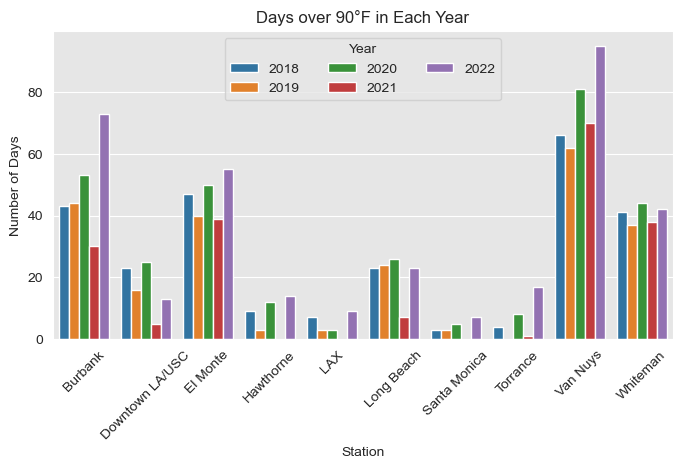

In [25]:
daily_high_df = low_high_df[['date_time', 'heat_index_high', 'stid']]
above_90 = daily_high_df[daily_high_df['heat_index_high']>90].groupby([daily_high_df.date_time.dt.year,'stid']).count()
above_90 = above_90['heat_index_high'].reset_index()
above_90.rename(columns={'date_time': 'year', 'stid': 'station', 'heat_index_high': 'heat_days'}, inplace=True)

station_places = {v: k for k, v in stations.items()}
above_90['place'] = above_90['station'].map(station_places)
above_90.head()

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(8,4))

sns.barplot(above_90, 
            x='place', 
            y='heat_days', 
            hue='year'
        )

plt.xlabel('Station')
plt.ylabel('Number of Days')
plt.legend(title='Year', loc=9, ncols=3)
plt.xticks(rotation=45)
plt.title(f'Days over 90°F in Each Year')